**1. IMPORT LIBRARIES**

In [ ]:
import os, re, random, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from zipfile import ZipFile
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style="whitegrid")

**Dataset Download and Extraction**

In [ ]:
def download_and_extract_oasis(data_dir="/content/data", zip_name="imagesoasis.zip"):
    os.makedirs(data_dir, exist_ok=True)
    zip_path = os.path.join(data_dir, zip_name)

    subprocess.run([
        "curl", "-L", "-o", zip_path,
        "https://www.kaggle.com/api/v1/datasets/download/ninadaithal/imagesoasis"
    ], check=True)

    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(data_dir, "imagesoasis"))

    print(f"Dataset downloaded and extracted to: {os.path.join(data_dir, 'imagesoasis')}")

In [ ]:
download_and_extract_oasis()

Dataset downloaded and extracted to: /content/data/imagesoasis


**LOAD DATA INTO DATAFRAME**

In [ ]:
CLASS_MAP = {
    "Non Demented": 0,
    "Very mild Dementia": 1,
    "Mild Dementia": 2,
    "Moderate Dementia": 3
}


**Data Loading and Preprocessing**

In [ ]:
def load_all_oasis_data(root="/content/data/imagesoasis/Data"):
    filepaths = []
    labels = []

    for cname in CLASS_MAP.keys():
        class_dir = os.path.join(root, cname)
        if not os.path.exists(class_dir):
            print(f"Missing folder: {class_dir}")
            continue

        for fname in os.listdir(class_dir):
            if fname.lower().endswith(".jpg"):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(cname)

    df = pd.DataFrame({"filepaths": filepaths, "labels": labels})
    print("Total images:", len(df))
    return df


Total images: 86437


In [ ]:
df = load_all_oasis_data()

Total images: 86437


In [ ]:
df.head()

,filepaths,labels
0,/content/data/imagesoasis/Data/Non Demented/OA...,Non Demented
1,/content/data/imagesoasis/Data/Non Demented/OA...,Non Demented
2,/content/data/imagesoasis/Data/Non Demented/OA...,Non Demented
3,/content/data/imagesoasis/Data/Non Demented/OA...,Non Demented
4,/content/data/imagesoasis/Data/Non Demented/OA...,Non Demented


**Exploratory Data Analysis**

In [ ]:
print(f"Total images: {len(df)}")

Total images: 86437


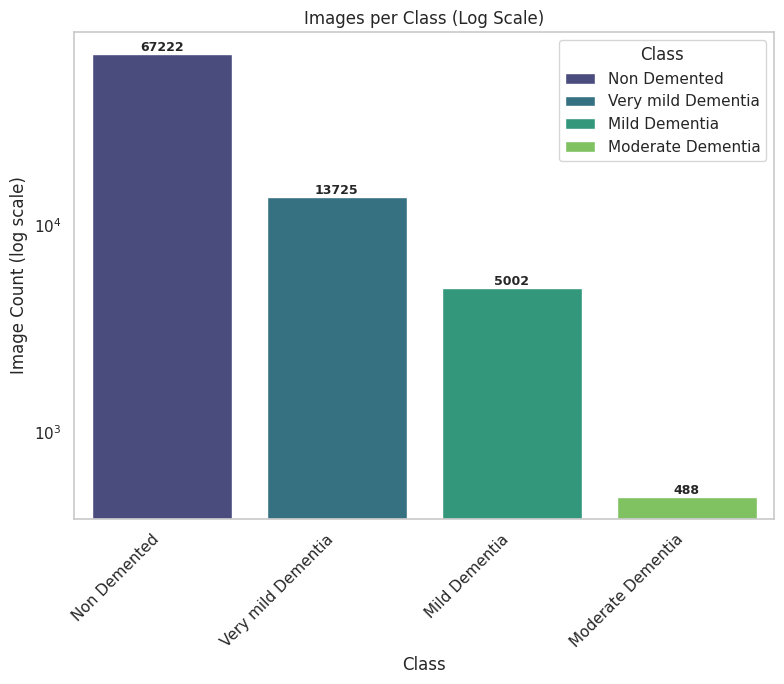

In [ ]:
def plot_class_distribution(df):
    img_counts = df['labels'].value_counts().reset_index()
    img_counts.columns = ['Class', 'Count']

    plt.figure(figsize=(8,7))
    sns.barplot(data=img_counts, x='Class', y='Count', hue='Class',
                dodge=False, palette='viridis',legend = True)

    plt.yscale('log')
    plt.title("Images per Class (Log Scale)")
    plt.ylabel("Image Count (log scale)")
    plt.xlabel("Class")
    plt.xticks(rotation=45, ha='right')

    for i, v in enumerate(img_counts['Count']):
        plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_class_distribution(df)

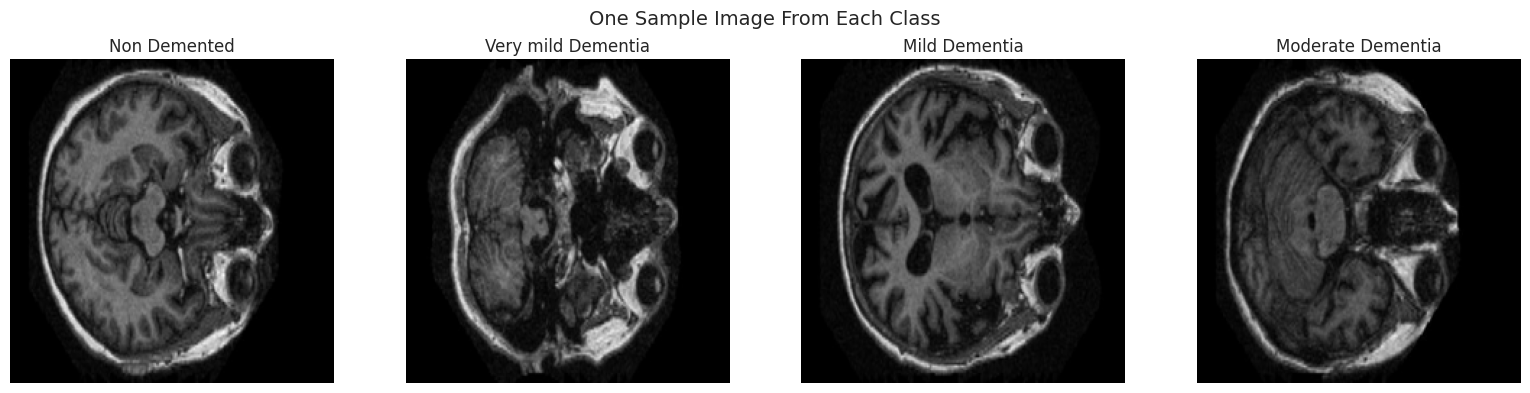

In [ ]:
def show_one_sample_per_class(df, num_classes=4):
    classes = df['labels'].unique()[:num_classes]
    plt.figure(figsize=(4 * num_classes, 4))

    for i, cl in enumerate(classes):
        sample_path = df[df['labels'] == cl]['filepaths'].sample(1).values[0]

        img = Image.open(sample_path).convert('RGB').resize((224, 224))

        plt.subplot(1, num_classes, i + 1)
        plt.imshow(img)
        plt.title(cl)
        plt.axis('off')

    plt.suptitle("One Sample Image From Each Class", fontsize=14)
    plt.tight_layout()
    plt.show()

show_one_sample_per_class(df)

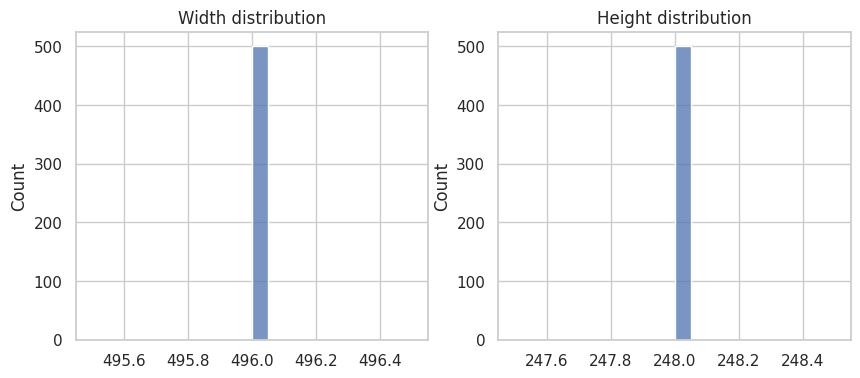

In [ ]:
def image_size_distribution(df):
    sizes = []
    for p in df['filepaths'].sample(min(500, len(df)), random_state=1).values:
        try:
            w,h = Image.open(p).size
            sizes.append((w,h))
        except:
            continue
    if sizes:
        w,h = zip(*sizes)
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        sns.histplot(w, bins=20); plt.title("Width distribution")
        plt.subplot(1,2,2)
        sns.histplot(h, bins=20); plt.title("Height distribution")
        plt.show()

image_size_distribution(df)

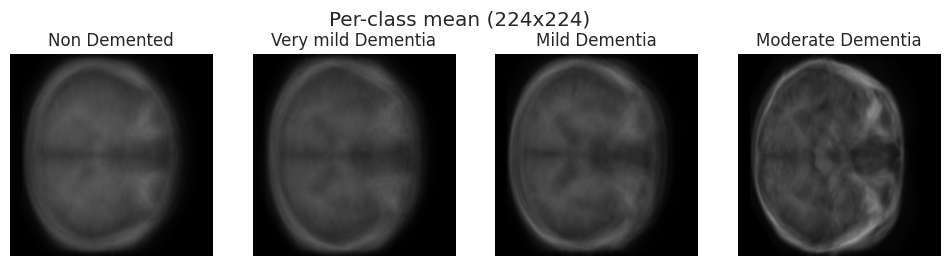

In [ ]:
def per_class_mean_image(df):
    classes = df['labels'].unique()
    plt.figure(figsize=(12,3))
    for i, cl in enumerate(classes):
        paths = df[df['labels']==cl]['filepaths'].sample(n=min(200, df[df['labels']==cl].shape[0]), random_state=1).values
        acc = np.zeros((224,224,3))
        count=0
        for p in paths:
            try:
                img = np.array(Image.open(p).convert('RGB').resize((224,224))) / 255.
                acc += img
                count += 1
            except: pass
        if count>0:
            mean_img = acc / count
            plt.subplot(1,len(classes),i+1)
            plt.imshow(mean_img)
            plt.title(cl)
            plt.axis('off')
    plt.suptitle("Per-class mean (224x224)")
    plt.show()

per_class_mean_image(df)

**DATASET SPLITTING**

In [ ]:
train_df, test_df = train_test_split(
    df, test_size=0.20, random_state=42, stratify=df["labels"]
)

train_df, val_df = train_test_split(
    train_df, test_size=0.20, random_state=42, stratify=train_df["labels"]
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (55319, 2)
Val: (13830, 2)
Test: (17288, 2)


**CLASS WEIGHTS**

In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['labels']),
    y=train_df['labels']
)

class_weights = {i: w for i, w in enumerate(class_weights)}
print("\nCLASS WEIGHTS:", class_weights)


CLASS WEIGHTS: {0: np.float64(4.319097439100562), 1: np.float64(44.326121794871796), 2: np.float64(0.3214650984402966), 3: np.float64(1.5744250910746813)}


**DATA AUGMENTATION**

In [ ]:
img_size = (100, 100)
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255.)

train_data = train_gen.flow_from_dataframe(
    train_df, x_col="filepaths", y_col="labels",
    target_size=img_size, class_mode="categorical",
    batch_size=batch_size, shuffle=True
)

validation_data = val_gen.flow_from_dataframe(
    val_df, x_col="filepaths", y_col="labels",
    target_size=img_size, class_mode="categorical",
    batch_size=batch_size, shuffle=False
)

test_data = test_gen.flow_from_dataframe(
    test_df, x_col="filepaths", y_col="labels",
    target_size=img_size, class_mode="categorical",
    batch_size=batch_size, shuffle=False
)


Found 55319 validated image filenames belonging to 4 classes.
Found 13830 validated image filenames belonging to 4 classes.
Found 17288 validated image filenames belonging to 4 classes.


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.6 MB/s eta 0:00:00


**HYPERPARAMETER TUNING**

In [ ]:
import kerastuner as kt

def model_builder(hp):
    hp_lr = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    hp_dropout = hp.Choice('dropout_rate', [0.3, 0.4, 0.5])

    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(100,100,3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(hp_dropout),

        # Block 2
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(hp_dropout),

        # Block 3
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(hp_dropout),

        # Dense
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(hp_dropout),

        layers.Dense(4, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# Random Search Tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='oasis_cnn'
)

tuner.search(
    train_data,
    validation_data=validation_data,
    epochs=5  # As per slide
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best LR:", best_hp.get('learning_rate'))
print("Best Dropout:", best_hp.get('dropout_rate'))

# Build best model
model = tuner.hypermodel.build(best_hp)


Trial 25 Complete [00h 03m 58s]
val_accuracy: 0.907816333770752

Best val_accuracy So Far: 0.927816333770752
Total elapsed time: 00h 06m 27s
Best LR: 0.001
Best Dropout: 0.4


**Model Training**

In [ ]:
def build_custom_cnn(input_shape=(100,100,3), num_classes=4):
    model = models.Sequential([

        # --- Block 1 ---
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.25),

        # --- Block 2 ---
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.30),

        # --- Block 3 ---
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.35),

        # --- Block 4 ---
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.40),

        # --- Dense layers ---
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


model = build_custom_cnn()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,946,596 (11.24 MB)

 Trainable params: 2,944,676 (11.23 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 219s 116ms/step - accuracy: 0.4516 - loss: 1.5904 - val_accuracy: 0.6308 - val_loss: 0.9397
Epoch 2/50
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 184s 106ms/step - accuracy: 0.7591 - loss: 0.6478 - val_accuracy: 0.6960 - val_loss: 0.8704
Epoch 3/50
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 184s 106ms/step - accuracy: 0.7857 - loss: 0.5350 - val_accuracy: 0.7422 - val_loss: 0.6193
Epoch 4/50
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 180s 104ms/step - accuracy: 0.7934 - loss: 0.4918 - val_accuracy: 0.7181 - val_loss: 0.6488
Epoch 5/50
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 180s 104ms/step - accuracy: 0.8066 - loss: 0.4646 - val_accuracy: 0.7126 - val_loss: 0.6389
Epoch 6/50
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 178s 103ms/step - accuracy: 0.8167 - loss: 0.4295 - val_accuracy: 0.7112 - val_loss: 0.6441
Epoch 7/50
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 177s 102ms/step - accuracy: 0.8276 - loss: 0.4095 - val_accuracy: 0.7436 - val_loss: 0.6268
Epoch 8/50
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 176s 102ms/step - ac

**Training and Validation Plots**

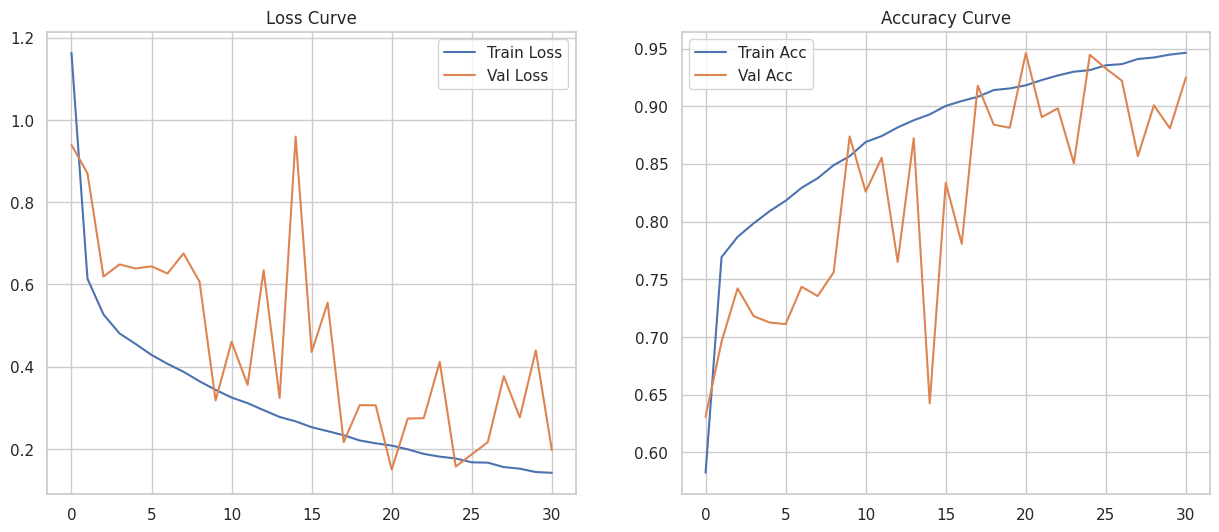

In [ ]:
hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(hist_df["loss"], label="Train Loss")
plt.plot(hist_df["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(hist_df["accuracy"], label="Train Acc")
plt.plot(hist_df["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

**Evaluation**

In [ ]:
loss, acc = model.evaluate(test_data)
print("TEST LOSS:", loss)
print("TEST ACCURACY:", acc)

541/541 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9473 - loss: 0.1416
TEST LOSS: 0.14959801733493805
TEST ACCURACY: 0.9438338875770569


541/541 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step
                    precision    recall  f1-score   support

     Mild Dementia       0.98      0.79      0.87      1000
 Moderate Dementia       0.95      0.83      0.89        98
      Non Demented       0.98      0.96      0.97     13445
Very mild Dementia       0.78      0.92      0.85      2745

          accuracy                           0.94     17288
         macro avg       0.93      0.87      0.89     17288
      weighted avg       0.95      0.94      0.94     17288


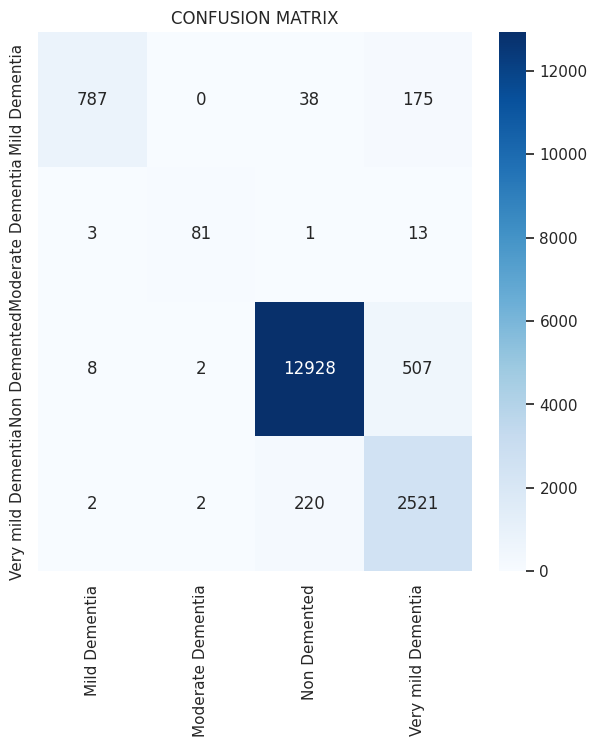

In [ ]:
y_true = test_data.classes
pred = model.predict(test_data)
y_pred = np.argmax(pred, axis=1)

class_names = list(test_data.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("CONFUSION MATRIX")
plt.show()
